# Insurance Cost Predictions

Insurance cost varies a lot across the United States. These costs are determined by lots of factors like age, gender, BMI, whether the person is smoking or not, or even the number of children and region where they live. 

In this project, I will apply regression algorithms to predict medical insurance costs for individuals. 

Data description: 
* age: age of primary beneficiary
* sex: insurance contractor gender, female, male
* bmi: body mass index, providing an understanding of body, weights that are relatively high or low relative to height, objective index of body weight (kg / m ^ 2) using the ratio of height to weight, ideally 18.5 to 24.9
* children: number of children covered by health insurance 
* smoker: contains information if person is smoker or non smoker 
* region: the beneficiary's residential area in the US, northeast, southeast, southwest, northwest.
* charges: individual medical costs billed by health insurance

In [2]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns

import missingno as msno 

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.io as pio
pio.renderers.default = "png" #for switching interactive visualizations to static 

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

from sklearn.pipeline import Pipeline

from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LinearRegression,Ridge,Lasso,ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor


from sklearn.model_selection import GridSearchCV

from sklearn.metrics import r2_score, mean_squared_error

from yellowbrick.regressor import PredictionError, ResidualsPlot

from joblib import dump

import warnings
warnings.filterwarnings('ignore')

In [3]:
df = pd.read_csv('insurance.csv')

In [4]:
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


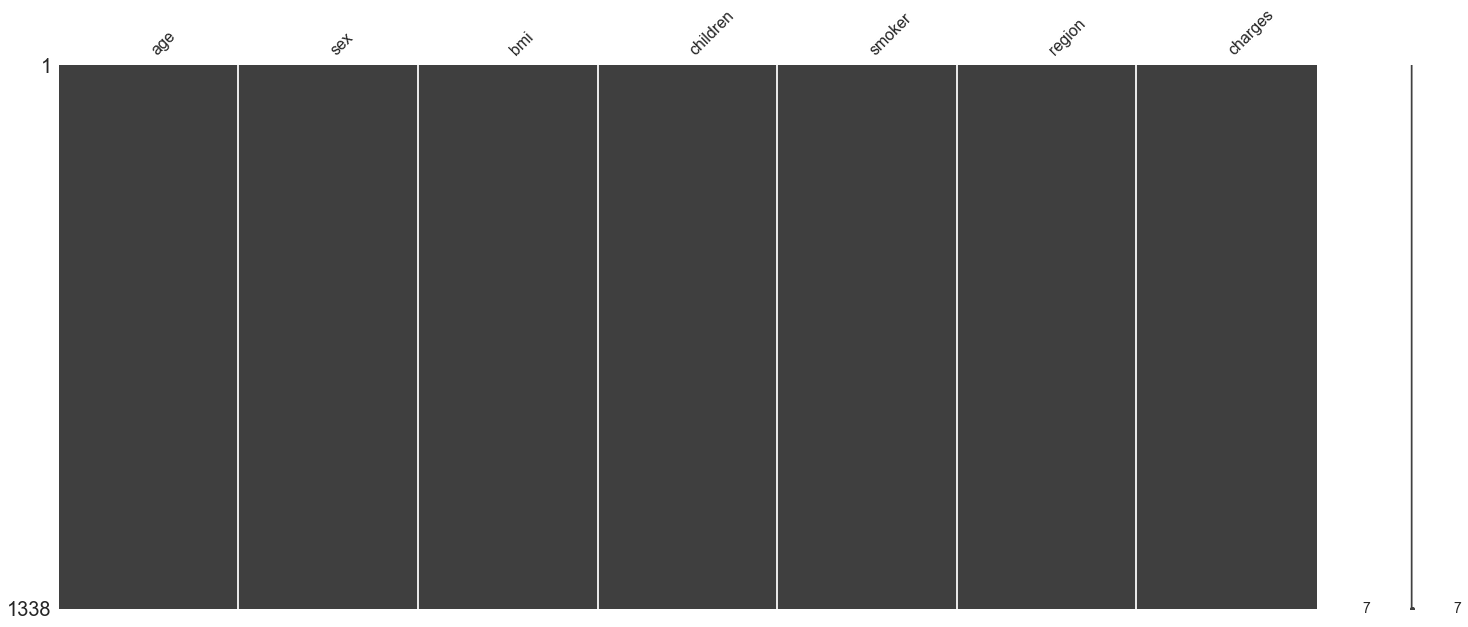

In [5]:
msno.matrix(df); # checking if dataset contains missing values

In [6]:
print(f'Number of observations: {df.shape[0]}')
print(f'Number of variables: {df.shape[1]}')

Number of observations: 1338
Number of variables: 7


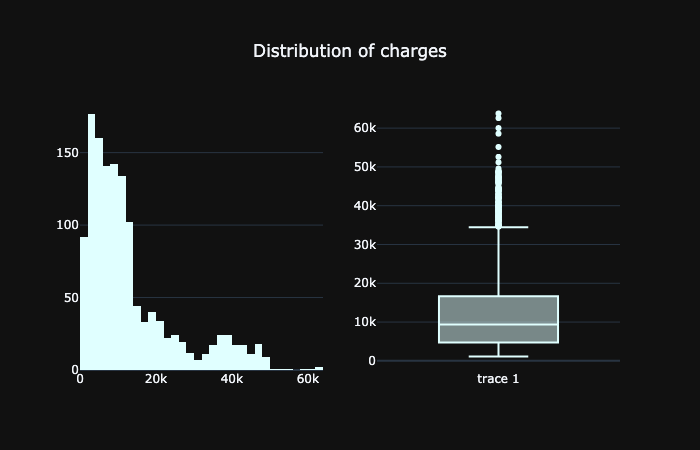

In [7]:
fig = make_subplots(rows=1,cols=2)
fig.add_histogram(x=df['charges'],marker_color='lightcyan',row=1,col=1)
fig.add_box(y=df['charges'],row=1,col=2,marker_color='lightcyan')
fig.update_layout(title={'text': "Distribution of charges",'y':0.9,'x':0.5,'xanchor': 'center','yanchor': 'top'})
fig.update_layout(showlegend=False)
fig.update_layout(template="plotly_dark")

In [8]:
df['age_bin'] = pd.cut(df['age'],bins=[0,35,55,100],labels=['young adults','middle-aged adults','older adults'])
df['age_bin'].value_counts()

young adults          574
middle-aged adults    548
older adults          216
Name: age_bin, dtype: int64

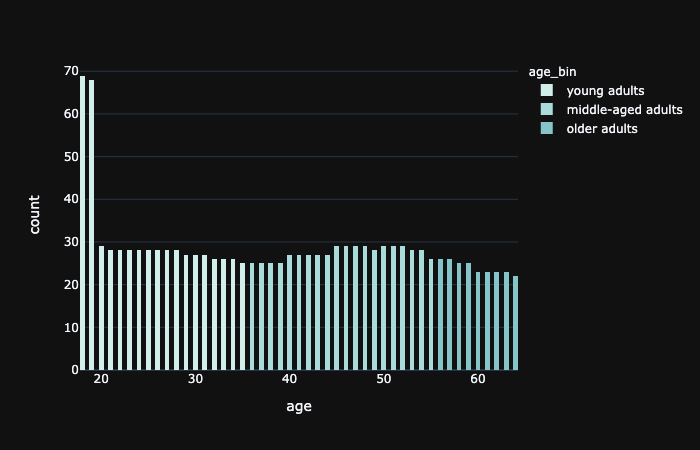

In [9]:
fig = px.histogram(df, x="age",color='age_bin',color_discrete_sequence=px.colors.sequential.Teal,nbins=100,width = 700, height = 400)
fig.update_layout(template="plotly_dark")
fig.show()

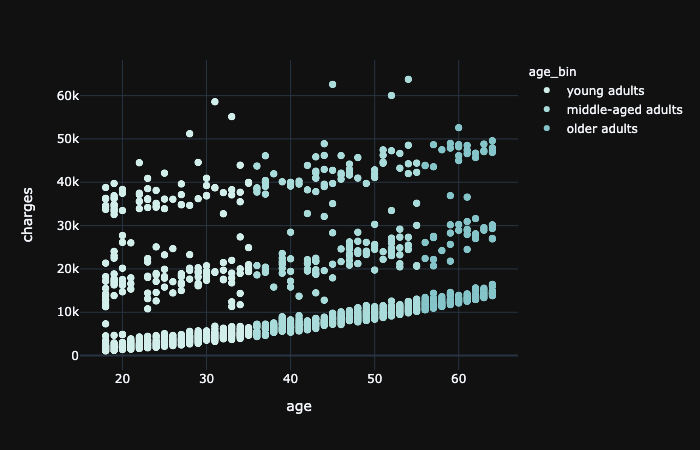

In [10]:
fig = px.scatter(df,x='age',y='charges', color='age_bin',color_discrete_sequence=px.colors.sequential.Teal,width = 700, height = 400)
fig.update_layout(template="plotly_dark")
fig.show()

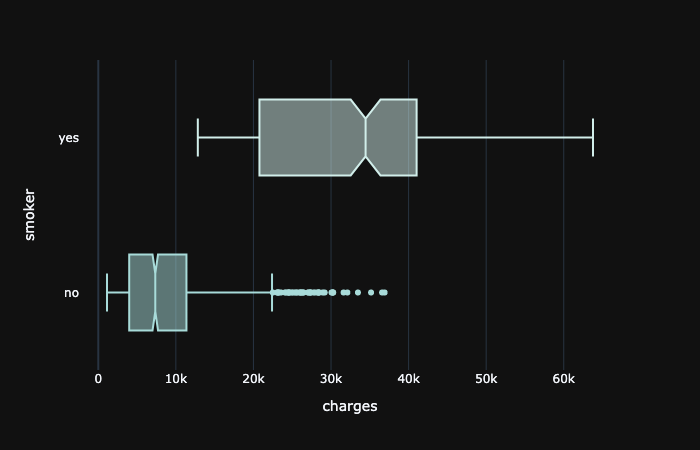

In [11]:
fig = px.box(df, x="charges", y="smoker",color='smoker',boxmode="overlay",color_discrete_sequence=px.colors.sequential.Teal,height=400,width=700,notched=True)
fig.update_layout(template="plotly_dark")
fig.update_layout(showlegend=False)
fig.update_traces(orientation='h')
fig.show()

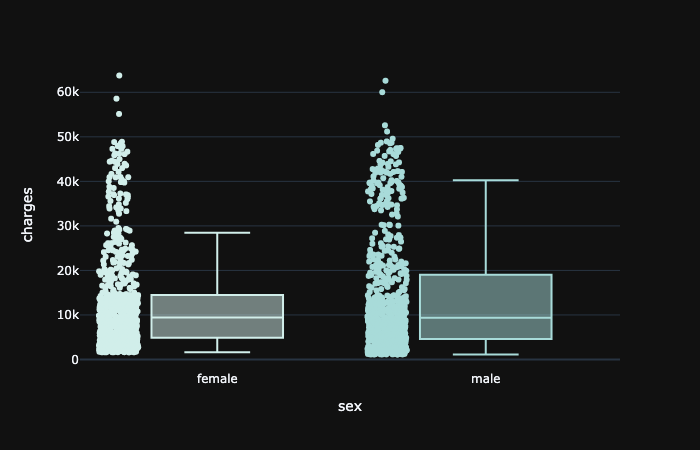

In [12]:
fig = px.box(df, x="sex", y="charges",color='sex',boxmode="overlay",color_discrete_sequence=px.colors.sequential.Teal,height=400,width=700,points='all')
fig.update_layout(template="plotly_dark")
fig.update_layout(showlegend=False)
fig.show()

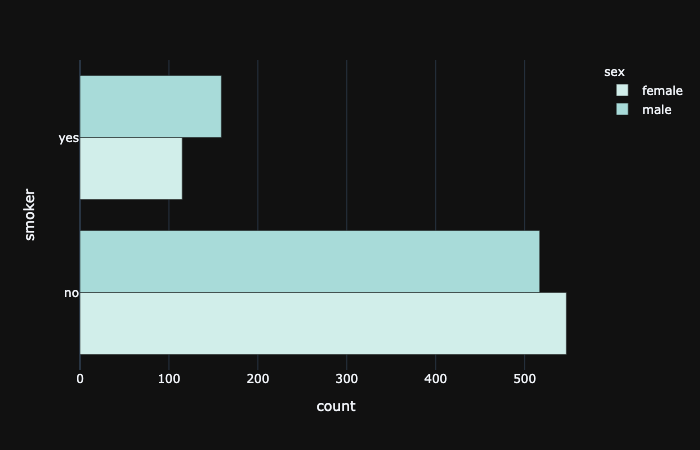

In [13]:
sex= df.groupby(['sex','smoker']).size().rename('count').reset_index().sort_values('sex')
fig = px.bar(sex, x="count", y='smoker', color='sex', barmode='group', height=400,width=700,color_discrete_sequence=px.colors.sequential.Teal)
fig.update_layout(template="plotly_dark")
fig.update_traces(orientation='h')
fig.show()

In [14]:
df['bmi_bin']=pd.cut(df['bmi'],bins=[0,16,17,18.5,25,30,35,40,100],labels=['very severly underweight','severly underweight','underweight','normal','overweight','obese class I','obese class II','obese class III'])
df['bmi_bin'].value_counts()

obese class I               389
overweight                  386
normal                      226
obese class II              225
obese class III              91
underweight                  18
severly underweight           2
very severly underweight      1
Name: bmi_bin, dtype: int64

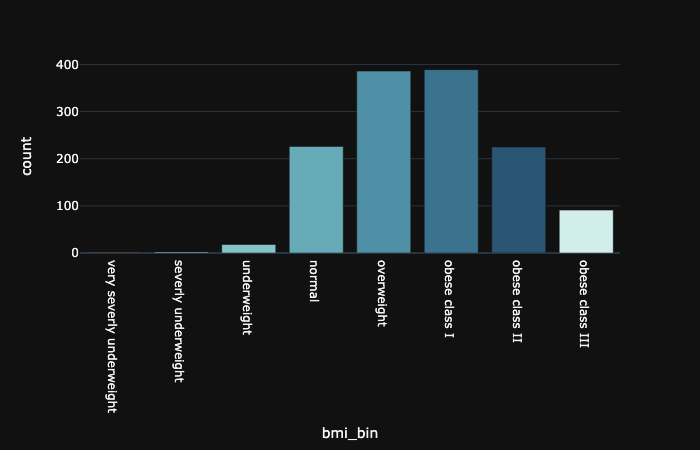

In [15]:
bmi= df.groupby(['bmi_bin']).size().rename('count').reset_index().sort_values('bmi_bin')
fig = px.bar(bmi, x='bmi_bin', y='count', color='bmi_bin',height=400,width=700,color_discrete_sequence=px.colors.sequential.Teal)
fig.update_layout(template="plotly_dark")
fig.update_layout(xaxis = dict(tickangle = 90))
fig.update_layout(showlegend=False)
fig.show()

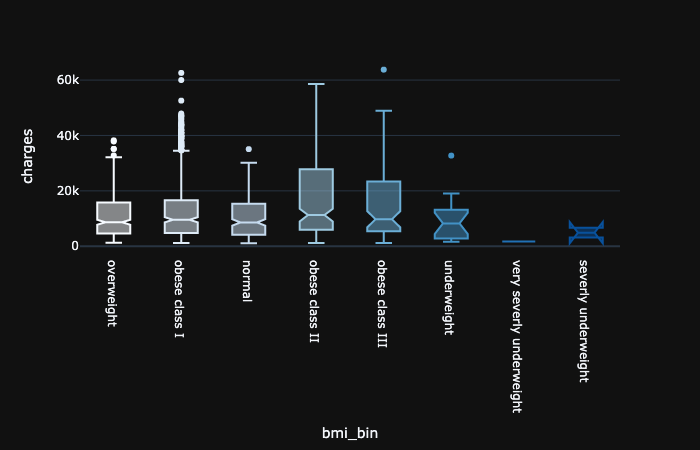

In [16]:
fig = px.box(df, x="bmi_bin", y="charges",color='bmi_bin',boxmode="overlay",color_discrete_sequence=px.colors.sequential.Blues,height=400,width=700,notched=True)
fig.update_layout(template="plotly_dark")
fig.update_layout(showlegend=False)
fig.update_layout(xaxis = dict(tickangle = 90))
fig.show()

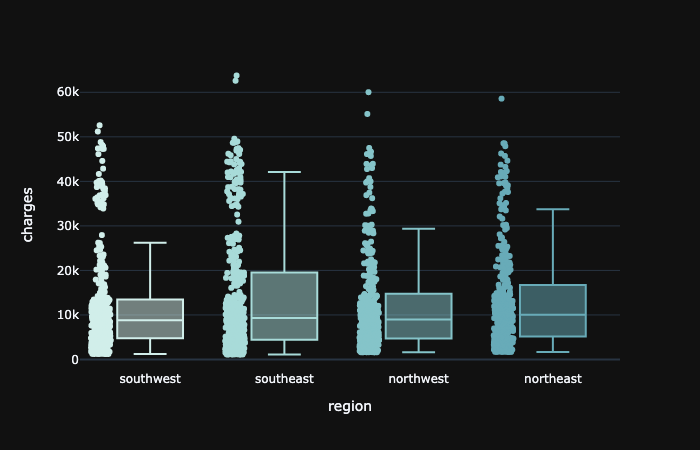

In [17]:
fig = px.box(df, x="region", y="charges",color='region',boxmode="overlay",color_discrete_sequence=px.colors.sequential.Teal,height=400,width=700,points='all')
fig.update_layout(template="plotly_dark")
fig.update_layout(showlegend=False)
fig.show()

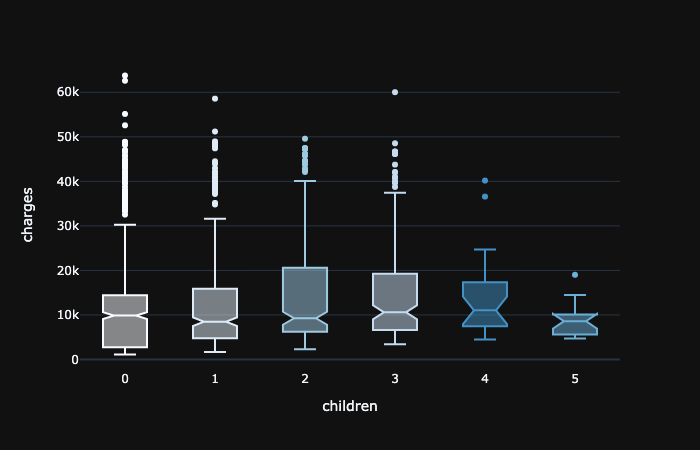

In [18]:
fig = px.box(df, x="children", y="charges",color='children',boxmode="overlay",color_discrete_sequence=px.colors.sequential.Blues,height=400,width=700,notched=True)
fig.update_layout(template="plotly_dark")
fig.update_layout(showlegend=False)
fig.show()

In [19]:
df['bmi_bin'] = df['bmi_bin'].astype('category')
df['bmi_bin'] = df['bmi_bin'].cat.codes
df.sample(5) 

,age,sex,bmi,children,smoker,region,charges,age_bin,bmi_bin
1250,24,male,29.830,0,yes,northeast,18648.42170,young adults,4
1008,25,male,24.985,2,no,northeast,23241.47453,young adults,3
728,18,female,40.280,0,no,northeast,2217.60120,young adults,7
1246,45,female,25.700,3,no,southwest,9101.79800,middle-aged adults,4
713,20,male,40.470,0,no,northeast,1984.45330,young adults,7


In [20]:
df['age_bin'] = df['age_bin'].astype('category')
df['age_bin'] = df['age_bin'].cat.codes
df.sample(5)  

,age,sex,bmi,children,smoker,region,charges,age_bin,bmi_bin
1313,19,female,34.70,2,yes,southwest,36397.5760,0,5
235,40,female,22.22,2,yes,southeast,19444.2658,1,3
4,32,male,28.88,0,no,northwest,3866.8552,0,4
1263,43,female,29.90,1,no,southwest,7337.7480,1,4
139,22,female,36.00,0,no,southwest,2166.7320,0,6


In [21]:
labelencoder = LabelEncoder() 
df['sex'] = labelencoder.fit_transform(df['sex'])
df['smoker'] = labelencoder.fit_transform(df['smoker'])
df['region'] = labelencoder.fit_transform(df['region'])
df.head()

,age,sex,bmi,children,smoker,region,charges,age_bin,bmi_bin
0,19,0,27.900,0,1,3,16884.92400,0,4
1,18,1,33.770,1,0,2,1725.55230,0,5
2,28,1,33.000,3,0,2,4449.46200,0,5
3,33,1,22.705,0,0,1,21984.47061,0,3
4,32,1,28.880,0,0,1,3866.85520,0,4


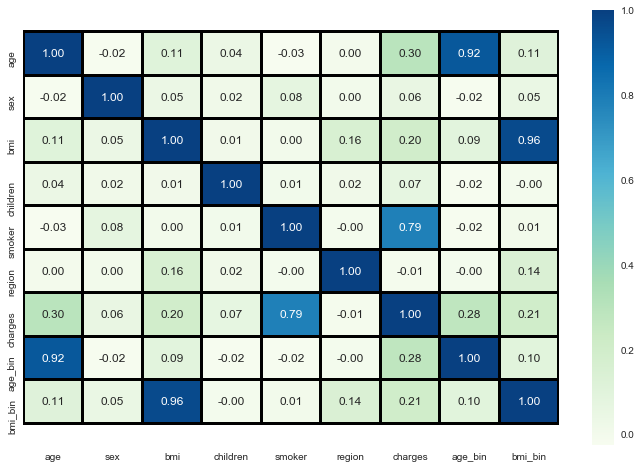

In [22]:
corr_matrix=df.corr()
fig, ax = plt.subplots(figsize=(12,8))
ax=sns.heatmap(corr_matrix,annot=True,fmt='.2f',cmap='GnBu',linewidths=2,linecolor='black')
bottom,top=ax.get_ylim()
bottom, top = ax.get_ylim()
ax.set_ylim(bottom+0.5,top-0.5); 

In [23]:
X=df.drop('charges',axis=1)
y=df['charges']

In [24]:
X_train, X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=0)

In [25]:
X.shape, y.shape

((1338, 8), (1338,))

### Linear Regression

In [26]:
linear = Pipeline([('scaler', StandardScaler()),
                     ('reg', LinearRegression ())])

In [27]:
linear.fit(X_train,y_train)
linear_train= linear.predict(X_train)
y_linear = linear.predict(X_test)

In [28]:
mse = [] # for saving mse scores 
mse.append((mean_squared_error(y_train,linear_train)))
r2_training = [] # saving r2 scores on training data
r2_training.append(r2_score(y_train,linear_train))
r2_test=[] # saving r2 scores on test data
r2_test.append(r2_score(y_test,y_linear))

In [29]:
def prediction_error(model):
    ''' Visualizing prediction error'''
    visualizer = PredictionError(model)
    visualizer.fit(X_train, y_train) 
    visualizer.score(X_test, y_test) 
    return visualizer.poof()

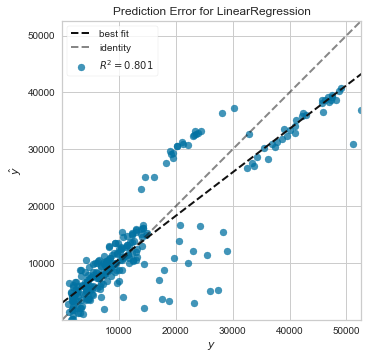

In [30]:
prediction_error(linear);

In [31]:
def residuals_plot(model):
    " Visualize residuals "
    visualizer = ResidualsPlot(model, hist=False)
    visualizer.fit(X_train, y_train)  
    visualizer.score(X_test, y_test)   
    return visualizer.poof()      

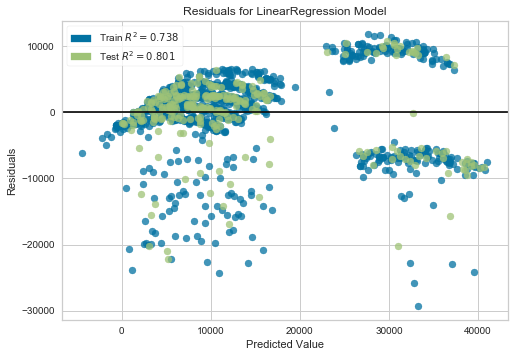

In [32]:
residuals_plot(linear);

### Polynomial Regression

In [33]:
polynomial = Pipeline([('scaler', StandardScaler()),
                      ('poly',PolynomialFeatures(2)),
                      ('reg', LinearRegression())])

In [34]:
polynomial.fit(X_train,y_train)
polynomial_train= polynomial.predict(X_train)
y_polynomial = polynomial.predict(X_test)

In [35]:
mse.append((mean_squared_error(y_train,polynomial_train)))
r2_training.append(r2_score(y_train,polynomial_train))
r2_test.append(r2_score(y_test,y_polynomial))

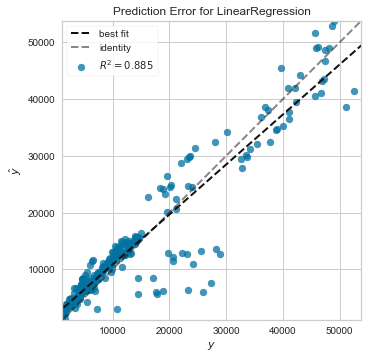

In [36]:
prediction_error(polynomial);

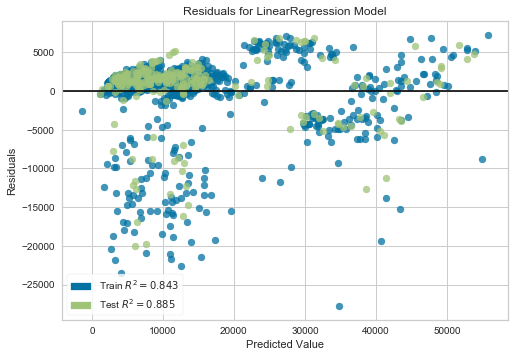

In [37]:
residuals_plot(polynomial);

### Elastic Net Regression

In [38]:
elastic_net = Pipeline([('scaler', StandardScaler()),
                    ('reg', ElasticNet())])
parameters= {'reg__alpha': [0.001, 0.01, 1.0],
             'reg__l1_ratio':[0.5,0.3,0.7]}
elastic = GridSearchCV(elastic_net, parameters, scoring='r2', cv=10)

In [39]:
elastic.fit(X_train,y_train)
elastic_train= elastic.predict(X_train)
y_elastic = elastic.predict(X_test)

In [40]:
elastic.best_params_

{'reg__alpha': 0.01, 'reg__l1_ratio': 0.3}

In [41]:
mse.append((mean_squared_error(y_train,elastic_train)))
r2_training.append(r2_score(y_train,elastic_train))
r2_test.append(r2_score(y_test,y_elastic))

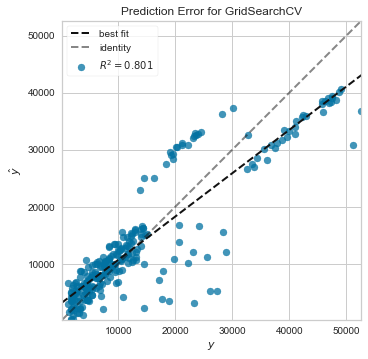

In [42]:
prediction_error(elastic);

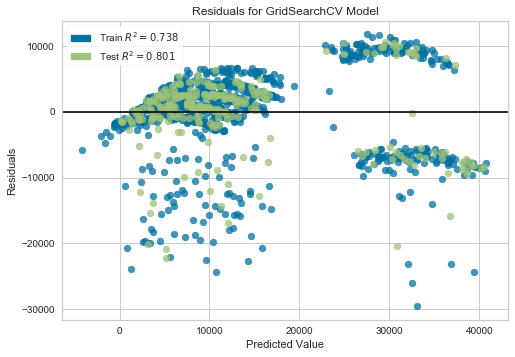

In [43]:
residuals_plot(elastic);

### Random Forest Regressor

In [44]:
random_forest = RandomForestRegressor()
parameters =  { "n_estimators": [100, 200],  
                "max_depth": [5,10],
                "min_samples_split": [15,20],
                "min_samples_leaf": [10,20] }
forest = GridSearchCV(random_forest, parameters, cv=10)

In [45]:
forest.fit(X_train,y_train)
forest_train= forest.predict(X_train)
y_forest = forest.predict(X_test)

In [46]:
forest.best_params_

{'max_depth': 5,
 'min_samples_leaf': 10,
 'min_samples_split': 15,
 'n_estimators': 100}

In [47]:
mse.append((mean_squared_error(y_train,forest_train)))
r2_training.append(r2_score(y_train,forest_train))
r2_test.append(r2_score(y_test,y_forest))

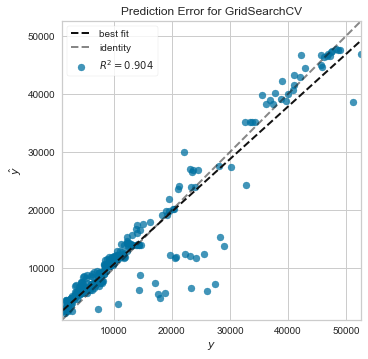

In [48]:
prediction_error(forest);

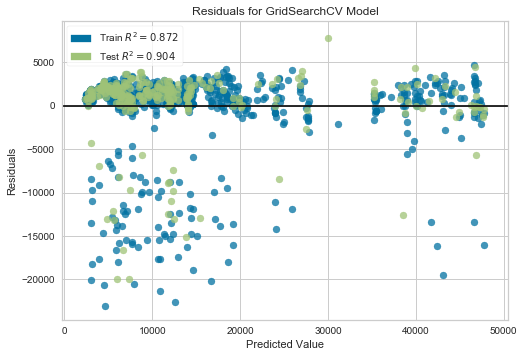

In [49]:
residuals_plot(forest);        

### Decision Tree Regressor

In [50]:
decision_tree = DecisionTreeRegressor()

In [51]:
parameters = {"min_samples_split": [10, 20, 40],
              "max_depth": [2, 5, 8],
              "min_samples_leaf": [20, 40, 100]}

In [52]:
tree = GridSearchCV(decision_tree, parameters, cv=10)

In [53]:
tree.fit(X_train,y_train)
tree_train= tree.predict(X_train)
y_tree = tree.predict(X_test)

In [54]:
tree.best_params_

{'max_depth': 5, 'min_samples_leaf': 20, 'min_samples_split': 40}

In [55]:
mse.append((mean_squared_error(y_train,tree_train)))
r2_training.append(r2_score(y_train,tree_train))
r2_test.append(r2_score(y_test,y_tree))

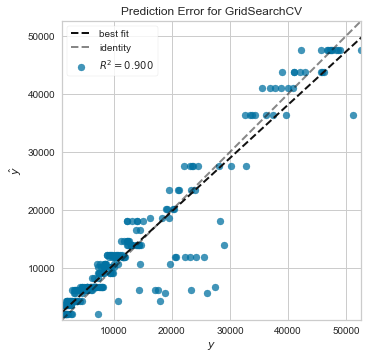

In [56]:
prediction_error(tree);

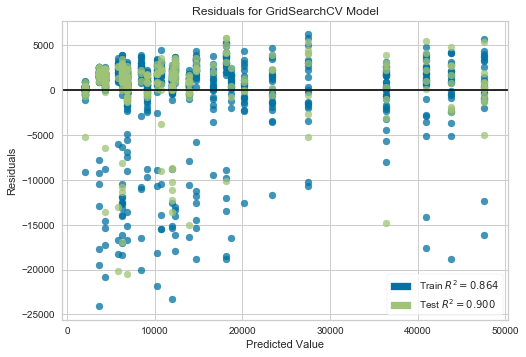

In [57]:
residuals_plot(tree);

--------------

In [58]:
names = ['LinearRegression','PolynomialRegression','ElasticNet','RandomForest','DecisionTree']
results = pd.DataFrame()
dictionary = dict(zip(names, r2_training))
results = pd.DataFrame.from_dict(dictionary, orient='index',columns=['R2 Training'])
results['R2 Test']=r2_test
results['MSE']=mse

In [59]:
results

,R2 Training,R2 Test,MSE
LinearRegression,0.738209,0.801325,3.753199e+07
PolynomialRegression,0.842788,0.885140,2.253887e+07
ElasticNet,0.738145,0.801031,3.754116e+07
RandomForest,0.872415,0.904444,1.829136e+07
DecisionTree,0.863551,0.899824,1.956223e+07


Random Forest model has the highest R2 score and lowest MSE. 

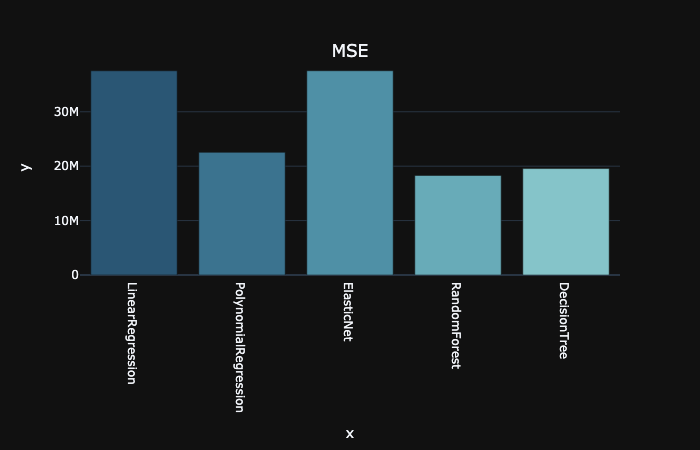

In [60]:
fig = px.bar(x=results.index, y=results['MSE'], color=results.index,height=400 ,width=700,color_discrete_sequence=px.colors.sequential.Teal_r)
fig.update_layout(template="plotly_dark")
fig.update_layout(showlegend=False)
fig.update_layout(xaxis = dict(tickangle = 90))
fig.update_layout(title={'text': "MSE",'y':0.9,'x':0.5,'xanchor': 'center','yanchor': 'top'})
fig.show()

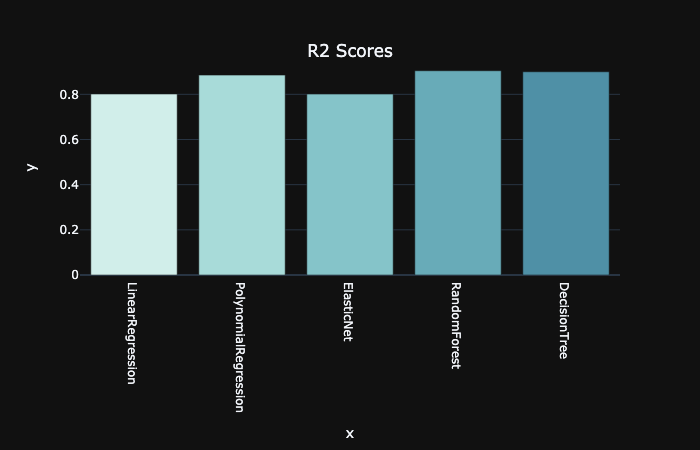

In [61]:
fig = px.bar(x=results.index, y=results['R2 Test'], color=results.index,  height=400,width=700,color_discrete_sequence=px.colors.sequential.Teal)
fig.update_layout(template="plotly_dark")
fig.update_layout(showlegend=False)
fig.update_layout(xaxis = dict(tickangle = 90))
fig.update_layout(title={'text': "R2 Scores",'y':0.9,'x':0.5,'xanchor': 'center','yanchor': 'top'})
fig.show()

In [62]:
# saving model with joblib
dump(forest,'insurance.joblib') 

['insurance.joblib']